In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import spacy
from ast import literal_eval
import folium
import re
from unidecode import unidecode



df1 = pd.read_csv('April 16 - June 12, 2021 T42 Screening Form Submissions.csv')
df2 = pd.read_csv('June 15 - August 11, 2021 T42 Screening Form Submissions.csv')
df3 = pd.read_csv("August 2021 T42 Screening.csv")

df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)
df.columns


Index(['Date', 'First Name', 'Middle Name', 'Last Name', 'Family Size', 'DOB',
       'Citizenship Country', 'Birth Country', 'Birth City', 'Gender',
       'Language', 'Height', 'Weight', 'Hair Color', 'Eye Color',
       'Marital Status', 'Phone Number', 'Phone Type', 'US Contact First Name',
       'US Contact Last Name', 'US Contact Phone Number',
       'US Contact Phone Type', 'US Contact Address',
       'US Contact Relationship', 'Displacement Date (left home country)',
       'Countries Visited ', 'Mexico Entry Date', 'Guatemala Entry Date',
       'Guatemala Exit Date ', 'El Salvador Entry Date',
       'El Salvador Exit Date ', 'Honduras Entry Date', 'Honduras Exit Date',
       'Nicaragua Entry Date', 'Nicaragua Exit Date', '# Returned to MX',
       'Only US Entry Date', 'Only US Exit Date', 'First US Entry Date',
       'First US Exit Date', 'Second US Entry Date', 'Second US Exit Date',
       'Third US Entry Date', 'Third US Exit Date', 'Fourth US Entry Date',
       'F

In [2]:
df['Language'].value_counts()

Language
Español     1489
Kekchi        23
Quiche        15
Chuj           7
Mam            6
English        5
Kanjobal       4
Soltero        4
Kreyol         3
Mixteco        2
Otro           1
Qeqchi         1
Name: count, dtype: int64

In [3]:
non_indigenous_languages = ["Español", "English","Kreyol"]

# Count the number of rows that don't have the specific value in the column
count = df["Language"].replace(non_indigenous_languages, None).value_counts().sum()
print(f"Percentage of Indigenous Language Speaking Parties - \033[1m{(count/len(df['Language'].dropna())):.2%}\033[0m")


Percentage of Indigenous Language Speaking Parties - 4.04%


In [4]:
df["Prior Deportation"].value_counts()

Prior Deportation
No       545
No sé     27
Si        22
Name: count, dtype: int64

In [5]:
replace_values = {"No he entrado a los Estados Unidos durante el último año.":"0",
                 "Más de 5": "5"
                 }
df["# Returned to MX"] = df["# Returned to MX"].replace(replace_values)
df["# Returned to MX"] = pd.to_numeric(df["# Returned to MX"], errors='coerce')
df["# Returned to MX"] = df["# Returned to MX"].fillna(-1).astype(int)

df["# Returned to MX"].value_counts()

# Returned to MX
 1     480
-1     461
 0     353
 2     168
 3      49
 4      30
 5      12
 6       5
 18      4
 11      2
Name: count, dtype: int64

1097
744
0.6782133090246126


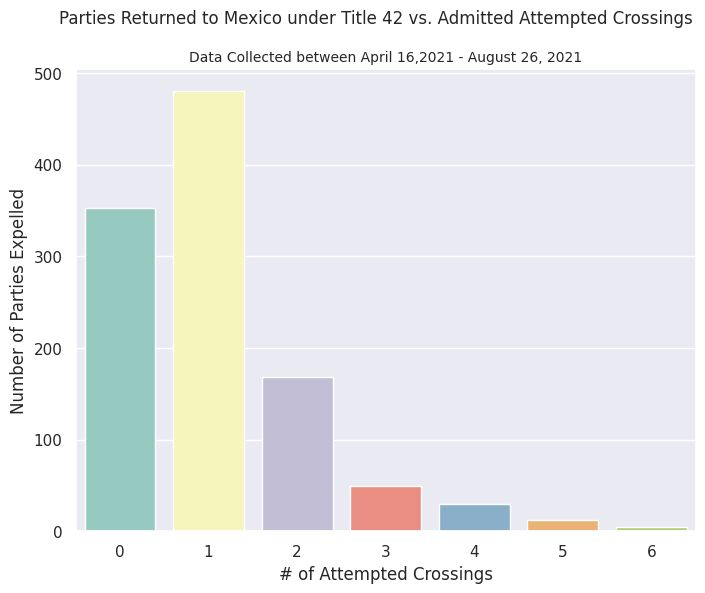

In [6]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
filtered_df = df[df['# Returned to MX'] != -1]
filtered_df = filtered_df[filtered_df['# Returned to MX'] != 11]
filtered_df = filtered_df[filtered_df['# Returned to MX'] != 18]
total = (filtered_df['# Returned to MX'].count())
number_removed = filtered_df[filtered_df['# Returned to MX'] != 0]['# Returned to MX'].count()
print(total)
print(number_removed)
print(number_removed/total)
sns.countplot(x='# Returned to MX', data=filtered_df, palette="Set3", hue="# Returned to MX", legend=False)
plt.suptitle('Parties Returned to Mexico under Title 42 vs. Admitted Attempted Crossings', fontsize=12)

# Customize the plot (optional)
plt.title('Data Collected between April 16,2021 - August 26, 2021', fontsize=10)
plt.xlabel('# of Attempted Crossings')
plt.ylabel('Number of Parties Expelled')

plt.savefig('Parties Returned to Mexico under Title 42.png', bbox_inches='tight')

# Show the plot
plt.show()

In [7]:
df["Hair Color"].value_counts()

Hair Color
Negro          1252
Marrón          166
Rubio            84
Desconocido      19
Rojo              8
Gris              7
Calvo             5
Arenoso           5
Blanco            4
Naranja           3
Verde             2
Name: count, dtype: int64

In [8]:
df["Only US Entry Date"].isna().sum()

1283

In [9]:
df["First US Entry Date"].isna().sum()

1401

In [10]:
df["Mexico Entry Date"].isna().sum()

822

In [11]:
df["Date of Leaving Mexico"] = df['First US Entry Date'].fillna(df['Only US Entry Date'])
df["Date of Leaving Mexico"].isna().sum()

1120

In [12]:
df['Date of Leaving Mexico'] = pd.to_datetime(df['Date of Leaving Mexico'], format='%d/%m/%Y')
df['Mexico Entry Date'] = pd.to_datetime(df['Mexico Entry Date'], format='%d/%m/%Y')
df["travel_time"] = df['Date of Leaving Mexico'] - df['Mexico Entry Date']

print(f"Average time through Mexico from date entered to day of first attempt at crossing: \033[1m {df['travel_time'].mean().days} days \033[0m")


Average time through Mexico from date entered to day of first attempt at crossing:  77 days 


In [13]:
df['Displacement Date (left home country)']

0       18/3/2021
1       18/3/2021
2        6/3/2021
3        6/3/2021
4        6/3/2021
          ...    
1559     3/2/2007
1560     8/8/2013
1561    20/1/2021
1562    18/5/2020
1563    18/5/2020
Name: Displacement Date (left home country), Length: 1564, dtype: object

In [14]:
import numpy as np
# Columns containing the word "Date"
date_columns = [col for col in df.columns if ('Date' in col and "US" not in col)]
objects_to_remove = set(('Date', 'Displacement Date (left home country)', 'Date of HIAS Referral '))
date_columns = [x for x in date_columns if x not in objects_to_remove]
print(date_columns)

for column in date_columns:
    df[column] = pd.to_datetime(df[column], format='mixed', dayfirst=True, errors='coerce')

def sort_and_remove_nan(row):
    sorted_values = sorted(row.dropna())
    if len(sorted_values)>1:
        return sorted_values
    else:
        return np.nan

# Apply the function to each row to create the new column
df['All Dates'] = df[date_columns].apply(sort_and_remove_nan, axis=1)

def calc_time(date_list):
    if type(date_list) is float:
        return date_list
    if len(date_list) <=1:
        return None
    return (date_list[-1] - date_list[0]).days
        

print(df['All Dates'].isna().sum())    

df['travel_time'] = df['All Dates'].apply(calc_time)

print(df['travel_time'].median())

['Mexico Entry Date', 'Guatemala Entry Date', 'Guatemala Exit Date ', 'El Salvador Entry Date', 'El Salvador Exit Date ', 'Honduras Entry Date', 'Honduras Exit Date', 'Nicaragua Entry Date', 'Nicaragua Exit Date', 'Date of Leaving Mexico']
1059
20.0


In [15]:
df['Kindapping, Trafficking, GBV'].value_counts()

Kindapping, Trafficking, GBV
Si    922
No    632
Name: count, dtype: int64

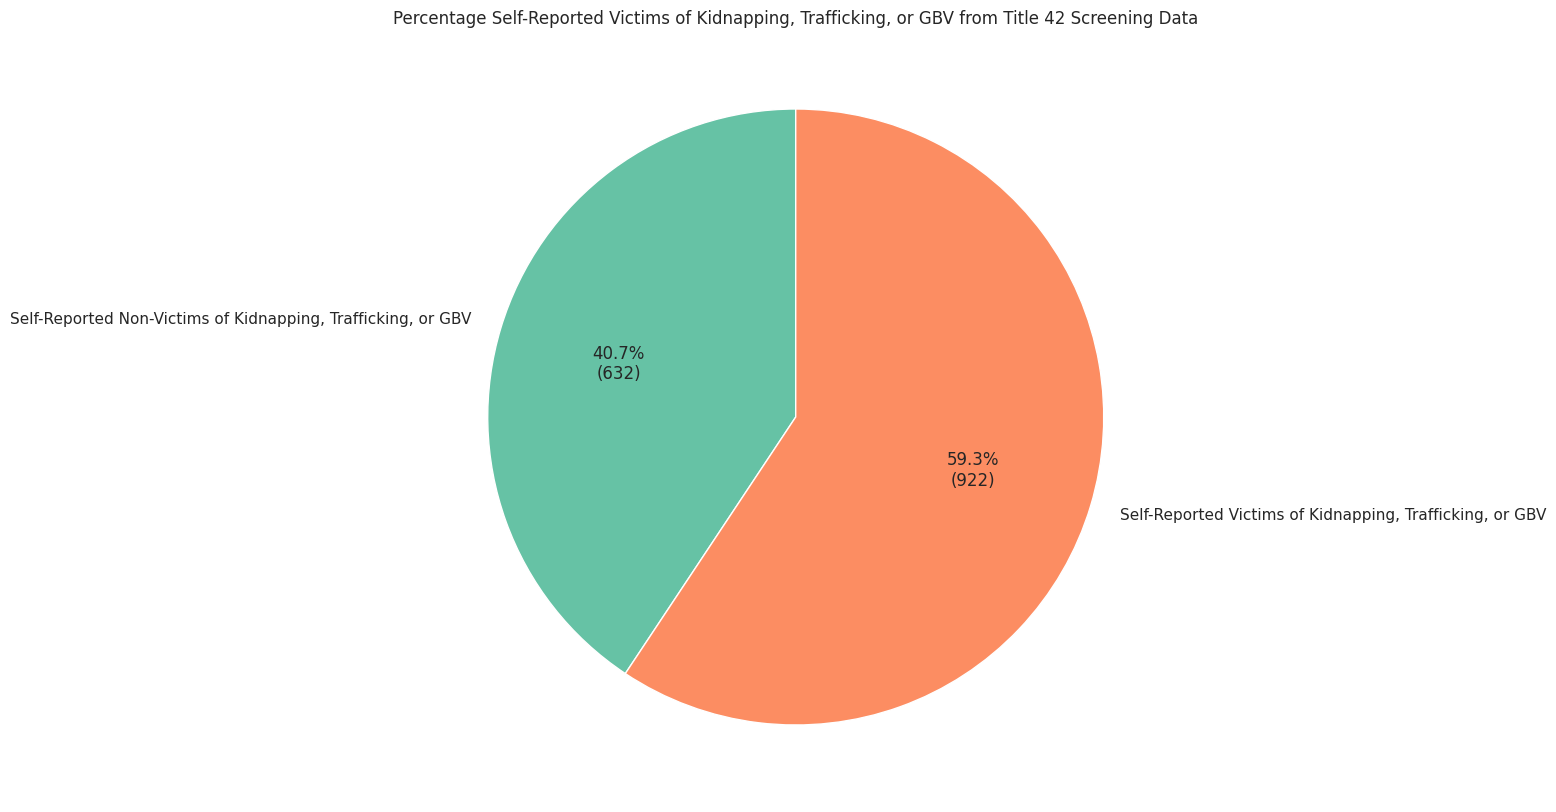

In [32]:
#counts = df['Kindapping, Trafficking, GBV'].value_counts()
#df['Kindapping, Trafficking, GBV'] = df['Kindapping, Trafficking, GBV'].replace("Si", "Yes")

counts = df['Kindapping, Trafficking, GBV'].value_counts()
# Create a pie chart using matplotlib.pyplot
plt.figure(figsize=(10, 12))


def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format
values = (counts.values.tolist())
values.reverse()
plt.pie(values, labels=["Self-Reported Non-Victims of Kidnapping, Trafficking, or GBV", "Self-Reported Victims of Kidnapping, Trafficking, or GBV"], autopct=autopct_format(counts), startangle=90, colors=plt.cm.Set2.colors)

# Customize the plot using Seaborn style
sns.set(style="whitegrid")
plt.title('Percentage Self-Reported Victims of Kidnapping, Trafficking, or GBV from Title 42 Screening Data')

plt.savefig("Victims of Kidnapping, Trafficking, GBV (from Title 42 Screening Data).png", bbox_inches='tight')


# Show the plot
plt.show()

In [17]:
df['US Contact Relationship'].isna().sum()

4

In [18]:
df['US Contact Relationship'] = df['US Contact Relationship'].str.lower()
df['US Contact Relationship'].value_counts()

US Contact Relationship
tia                                                                                              155
amigo                                                                                            152
tio                                                                                              115
amiga                                                                                            102
prima                                                                                             81
                                                                                                ... 
amiga de mama                                                                                      1
tio de mi mujer                                                                                    1
padrastro , me crie con el desde los 3 años hasta el 2015 que partio hacia los estados unidos      1
abuelo                                                             

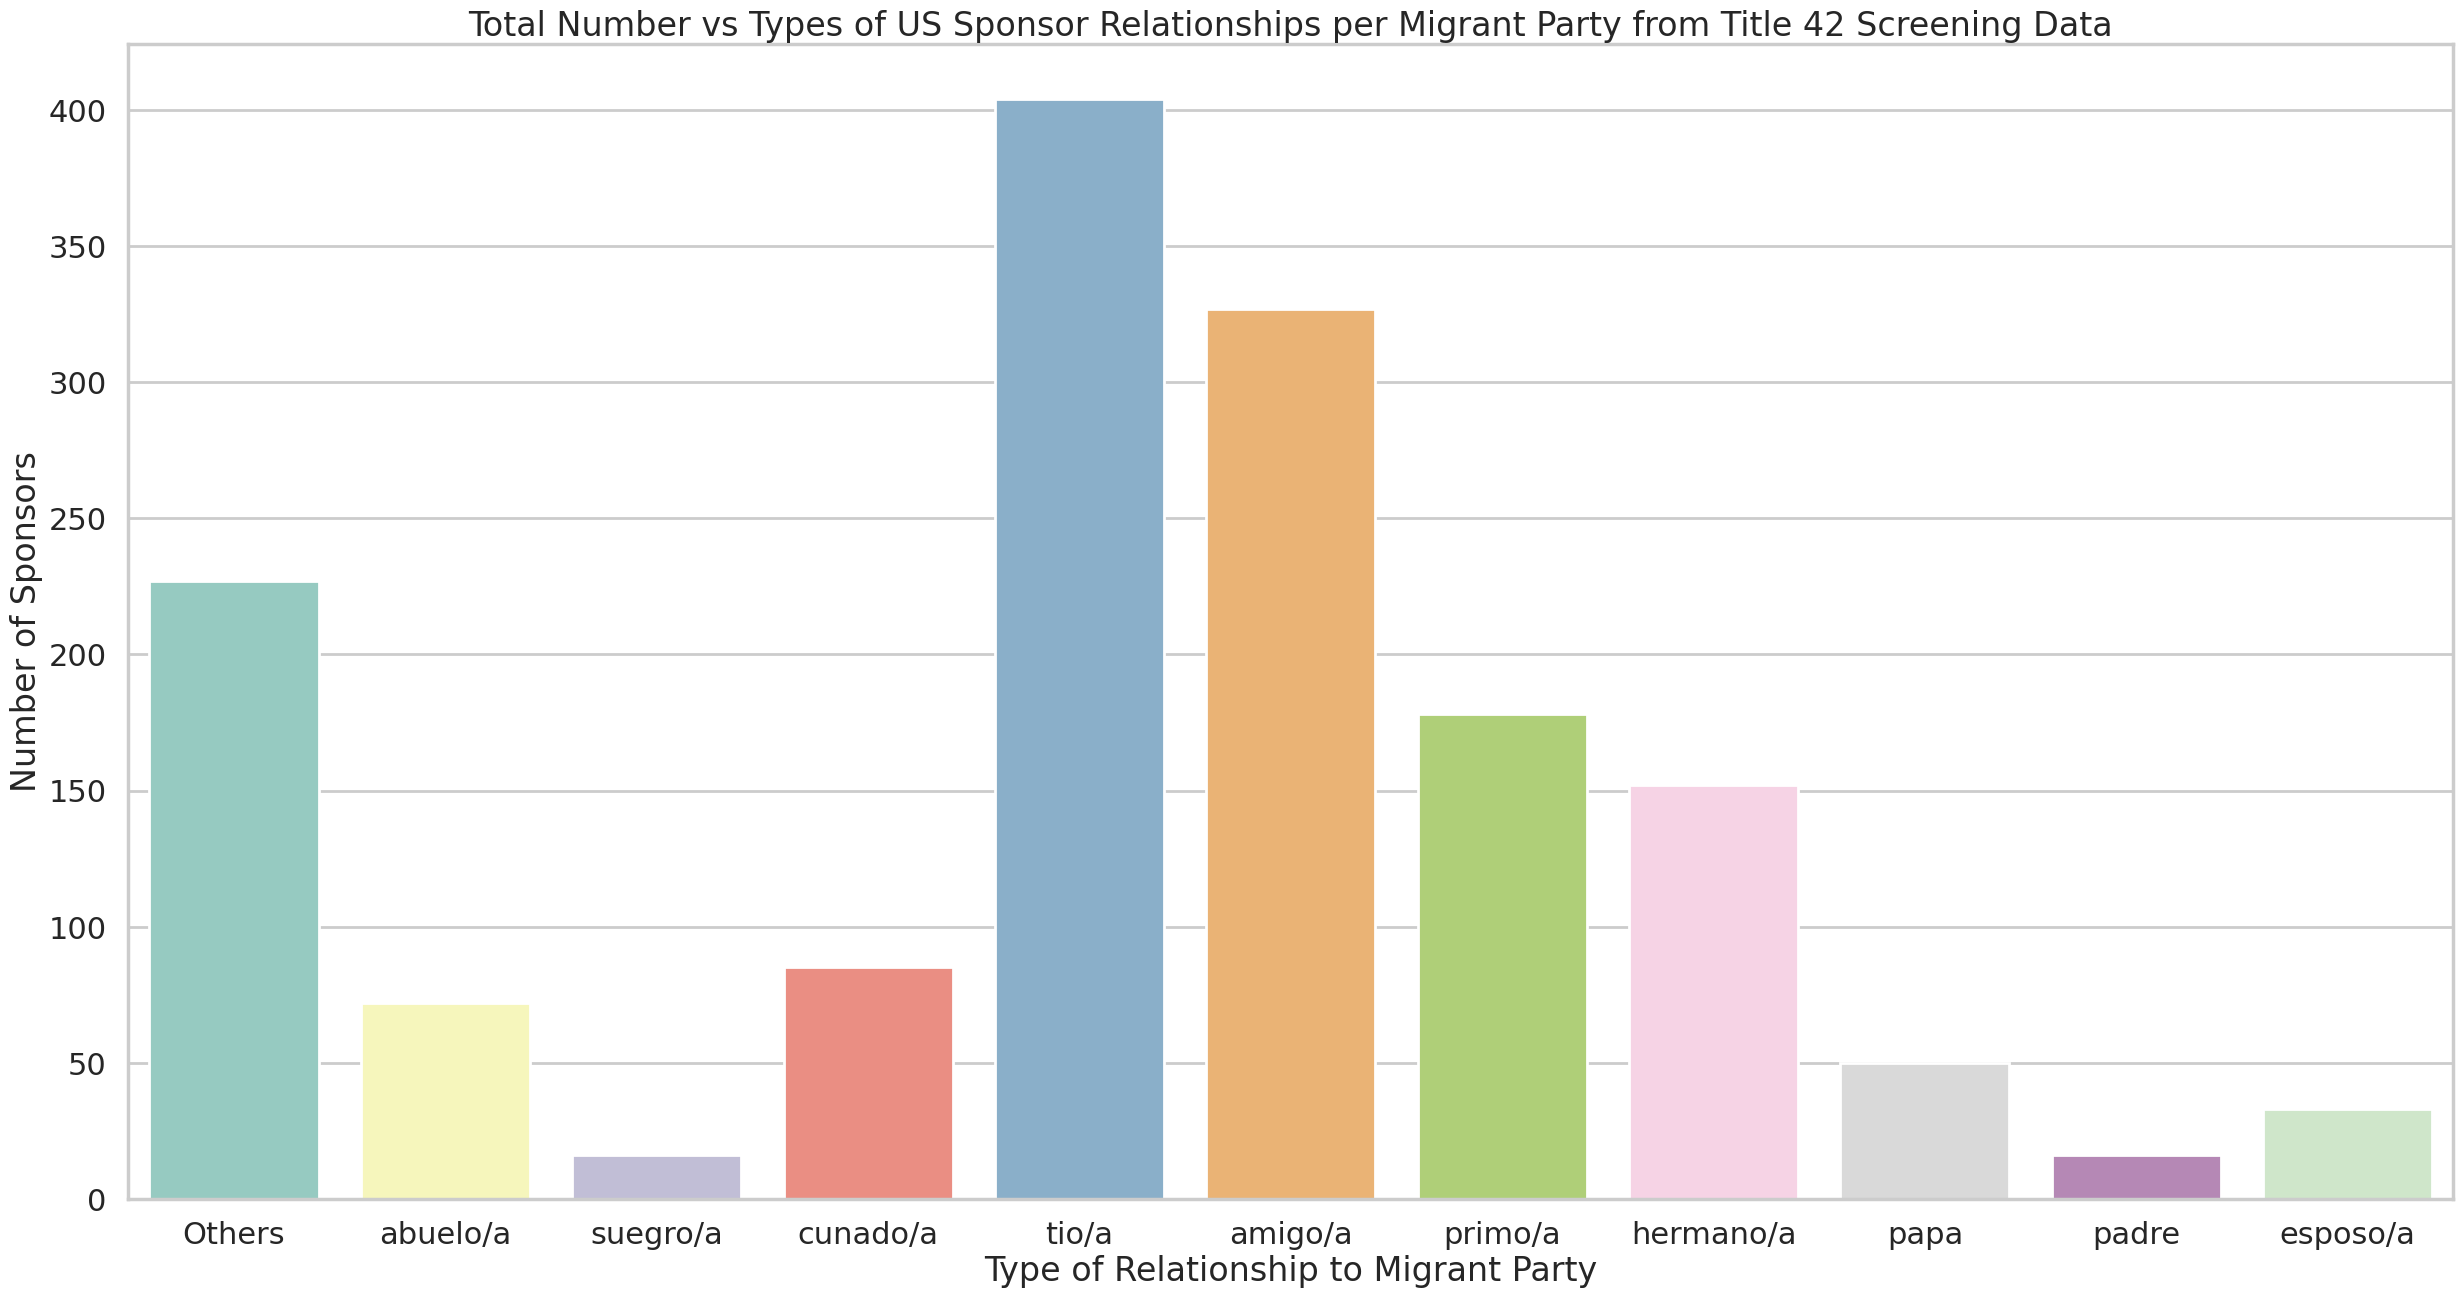

In [20]:
from numpy import nan as nan
value_counts = df['US Contact Relationship'].value_counts()

# Get the values that occur less than 20 times
common_values = (value_counts[value_counts > 10].index)
common_values = set([unidecode(item.rstrip()) for item in common_values])

#common_values.update(("papa", "mama", "esposo", "esposa", "bisabuela", "bisabuelo", "hija", "hijo","suegro", "suegra"))


def replace_values_common_ones(contact_relationship):
    if type(contact_relationship) is not str:
        return contact_relationship
        
    words_in_relationship_set = set(unidecode(contact_relationship).split()) #unidecode to remove accents, and split to turn the whole possible sentence into a list and then set to perfrom set operations
    relationship = common_values.intersection(words_in_relationship_set)
    if not relationship:
        return "Others"

    relationship = list(relationship)[0]  
    if (relationship[-1] == 'a' or relationship[-1] == 'o') and relationship != 'mama' and relationship != 'papa' and not relationship.endswith("o/a")  :
        relationship = relationship[:-1] + "o/a"
    return relationship
    
    

# Replace these rare values with a common label, for example, 'Others'
#df.loc[df['US Contact Relationship'].isin(rare_values), 'US Contact Relationship'] = 'Others'
df['US Contact Relationship'] = df['US Contact Relationship'].apply(replace_values_common_ones
                                                                   )

rare_values = set(value_counts[value_counts < 10].index)


df.loc[df['US Contact Relationship'].isin(rare_values), 'US Contact Relationship'] = 'Others'

sns.set_context("poster")  # Choose the appropriate context size
plt.figure(figsize = (30,15))
sns.countplot(x='US Contact Relationship', data=df, palette="Set3", hue="US Contact Relationship", legend=False)
#plt.suptitle('Parties Returned to Mexico under Title 42 vs. Admitted Attempted Crossings', fontsize=12)

# Customize the plot (optional)
plt.title('Total Number vs Types of US Sponsor Relationships per Migrant Party from Title 42 Screening Data')
plt.xlabel('Type of Relationship to Migrant Party')
plt.ylabel('Number of Sponsors')
plt.savefig("Total Number of Types of US Sponsor Relationship per Migrant Party.png")

# Show the plot
plt.show()

In [ ]:
import requests
url = 'https://raw.github.com/stopwords-iso/stopwords-es/master/stopwords-es.txt'
req = requests.get(url)
spanish_stopwords = set(STOPWORDS)
spanish_stopwords.update(req.content.decode("utf-8").split("\n"))
spanish_stopwords.update(["mes", "persona", "esposo", "primo","ciudad","calle","hijo","hija", "esposa", "wife", "daughter","son","problema", "problem", "dolor", "padecer", "hermano"])


# Lemmatize using spaCy on the original tokens
nlp = spacy.load('es_core_news_sm')


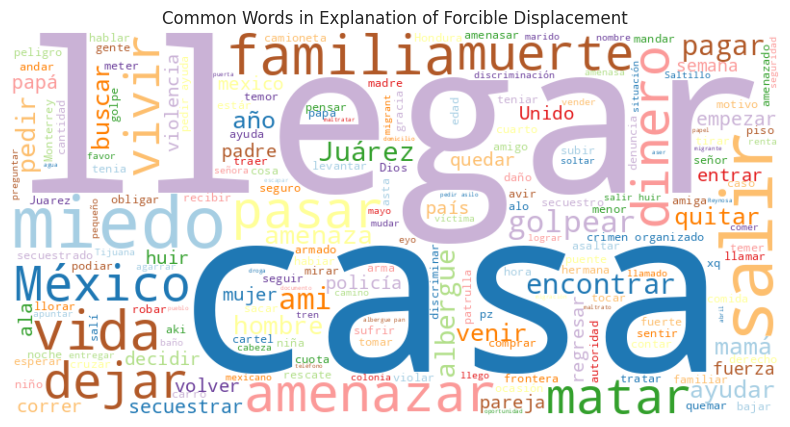

In [29]:

df_text = df.dropna(subset=['Forced Displacement Explain'])
text_data = ' '.join(df_text['Forced Displacement Explain'].astype(str))
tokens = word_tokenize(text_data)

# Lemmatize using spaCy on the original tokens
lemmatized_text = ' '.join([token.lemma_ for token in nlp(' '.join(tokens))])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, stopwords=spanish_stopwords, background_color='white', colormap="Paired").generate(lemmatized_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Explanation of Forcible Displacement", fontsize=12)
plt.savefig("Common Words in Explanation of Forcible Displacement.png")
plt.show()

In [36]:
value_counts = df['Forced Displacement'].value_counts()
percentages = ((value_counts / value_counts.sum()) * 100)
percentages

Forced Displacement
Si    61.503856
No    38.496144
Name: count, dtype: float64